In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import pandasql as ps
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from sklearn.preprocessing import StandardScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_samples, silhouette_score
import tensorflow as tf
import keras

In [2]:
# reading the datasets from the directory Datasets/SocioEconomic
# read the pop_stab dataframe up to 214 rows only
pop_stab =  pd.read_csv('../Datasets/SocioEconomic/political_stability_1996_2021.csv', nrows=214, na_values='..')
pop =  pd.read_csv('../Datasets/SocioEconomic/population_1960_2021.csv', na_values='..')
urban_pop =  pd.read_csv('../Datasets/SocioEconomic/Urban_pop_WorldBank_1960_2021.csv', skiprows=4)
gdp =  pd.read_csv('../Datasets/SocioEconomic/GDP_1960_2021.csv', na_values='..')
oil_prices = pd.read_csv('../Datasets/SocioEconomic/crude_oil_price_1983_2023.csv')
inflation =  pd.read_csv('../Datasets/SocioEconomic/Inflation_data_1970_2022.csv', encoding='ISO-8859-1')
co2_emission = pd.read_csv('../Datasets/SocioEconomic/co2_emission_2021.csv')
migration = pd.read_csv('../Datasets/SocioEconomic/migration_1960_2021.csv')
hdi_le = pd.read_csv('../Datasets/SocioEconomic/HDI_LE_1990_2021.csv')
country_codes = pd.read_csv('../Datasets/SocioEconomic/UN_country_code.csv')
fertility = pd.read_csv('../Datasets/SocioEconomic/fertility_1973_2021.csv', na_values='..')

## Cleaning Datasets
### Political Stability and Absence of Violence/Terrorism

The dataset under consideration contains information about the "Political Stability and Absence of Violence/Terrorism" index for various countries from the year 1996 to 2021. The index, coded as 'PV.EST', is measured on a scale from -2.5 to 2.5, with a higher value indicating more stable political conditions and less violence or terrorism. A lower score indicates a less stable political environment and higher levels of violence or terrorism.

Our data cleaning and preparation steps include:

- **Renaming columns**: The year columns are initially named in the format 'YYYY [YRYYYY]'. We rename these to just 'YYYY' for simplicity and ease of access.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

- **Handling missing years**: Our dataset does not include data for the years 1997, 1999, and 2001. We handle this by computing the missing values as the average of the previous and following years. This is done under the assumption that the political stability index changes smoothly over time.

- **Sorting columns**: After inserting the missing years, we sort our columns to maintain a chronological order of years.

- **Backward filling**: Some years at the beginning of the dataset have missing values. We fill these missing values using the backward fill method, which propagates the next valid observation backward to fill the gaps.


In [3]:
# renaming the columns by removing [YR]
pop_stab = pop_stab.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in pop_stab.columns[4:]})
# Change the type of year columns to float
for col in pop_stab.columns[4:]:
    pop_stab[col] = pop_stab[col].astype(float)

# renaming the columns by removing [YR]
pop_stab = pop_stab.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in pop_stab.columns[4:]})

In [4]:
# this function will fill the missing values with the mean of the previous and next year
def insert_missing_years(df, missing_years):
    for year in missing_years:
        prev_year = str(year - 1)
        next_year = str(year + 1)

        # Check if previous and next year columns exist
        if prev_year in df.columns and next_year in df.columns:
            df[prev_year] = pd.to_numeric(df[prev_year], errors='coerce')
            df[next_year] = pd.to_numeric(df[next_year], errors='coerce')
            df[str(year)] = (df[prev_year] + df[next_year]) / 2
        else:
            print(f"Cannot compute for year {year}, adjacent years data are not available.")
        
    # Sort the columns
    non_year_cols = ["Country Name", "Country Code", "Series Name", "Series Code"]
    year_cols = [str(i) for i in sorted(int(col) for col in df.columns if col.isdigit())]
    cols = non_year_cols + year_cols
    
    return df.reindex(columns=cols)

In [5]:
# certain years are missing from the dataframe
missing_years = [1997, 1999, 2001]

# fill the missing years
pop_stab = insert_missing_years(pop_stab, missing_years)

In [6]:
# there are certain years in the beginning of the dataframe that have missing values
# we will fill those missing values using the backward fill method
pop_stab.loc[:, '1996':] = pop_stab.loc[:, '1996':].bfill(axis=1)

### Population & Urban Population

The datasets under consideration contain information about the total population and the urban population as a percentage of the total population for various countries from the year 1960 to 2021.

Our data cleaning and preparation steps include:

- **Removing Null Values**: We start by removing any rows in our data that contain null values. This is important because null values can lead to errors in calculations and can be indicative of missing or incomplete data.

- **Renaming columns**: The year columns in our datasets are initially named in the format 'YYYY [YRYYYY]'. We rename these to just 'YYYY' for simplicity and ease of access.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.



In [7]:
# removing the null values
pop = pop.dropna()
# renaming the columns by removing [YR]
pop = pop.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in pop.columns})
# Change the type of year columns to float
for col in pop.columns[4:]:
    pop[col] = pop[col].astype(float)

In [8]:
# get all the rows for each country of interest
#urban_pop = urban_pop[urban_pop['Country Code'].isin(countries_of_interest)]
# removing the null values
urban_pop = urban_pop.dropna()
# Change the type of year columns to float
for col in urban_pop.columns[4:]:
    urban_pop[col] = urban_pop[col].astype(float)

### Human Development Index (HDI) and Life Expectancy (LE)

## Cleaning Datasets
### Human Development Index (HDI) and Life Expectancy at Birth (LE)

The datasets under consideration contain information about the Human Development Index (HDI) and Life Expectancy at Birth (LE) for various countries from the year 1990 to 2021.

Our data cleaning and preparation steps include:

- **Filtering columns**: We start by filtering our data to include only those columns related to HDI and LE. For HDI, the columns include 'iso3', 'country', and 'hdi_YEAR' for each year from 1996 to 2021. For LE, the columns include 'iso3', 'country', and 'le_YEAR' for each year from 1996 to 2021.

- **Renaming columns**: We rename the 'iso3' column to 'Country Code' and the 'country' column to 'Country Name' for better clarity and consistency.

- **Removing prefix from columns**: We remove the 'hdi_' prefix from the columns in the HDI dataframe and 'le_' prefix from the columns in the LE dataframe. This is done to make the column names simpler and more intuitive.

- **Backward filling**: Some years at the beginning of the dataset have missing values. We fill these missing values using the backward fill method, which propagates the next valid observation backward to fill the gaps.

- **Removing invalid countries**: We remove any countries that have null values after our data cleaning process.

In [9]:
# Filter the columns to include only those related to HDI
hdi_columns = ['iso3', 'country'] + [f'hdi_{year}' for year in range(1996, 2022)]
hdi_data = hdi_le[hdi_columns].copy()

# Rename the columns
hdi_data.rename(columns={'iso3': 'Country Code', 'country': 'Country Name'}, inplace=True)

# Remove 'hdi_' prefix from the columns in the HDI dataframe
hdi_data.columns = hdi_data.columns.str.replace('hdi_', '')

# Fill the missing values using backward fill
hdi_data.loc[:, '1996':] = hdi_data.loc[:, '1996':].bfill(axis=1)

# remove some invalid countries
hdi_data = hdi_data.dropna()

In [10]:
# Filter the columns to include only those related to Life expectancy
le_columns = ['iso3', 'country'] + [f'le_{year}' for year in range(1996, 2022)]
le_data = hdi_le[le_columns].copy()

# Rename the columns
le_data.rename(columns={'iso3': 'Country Code', 'country': 'Country Name'}, inplace=True)

# Remove 'le_' prefix from the columns in the Life expectancy dataframe
le_data.columns = le_data.columns.str.replace('le_', '')

### Gross Domestic Product

### Gross Domestic Product (GDP)

The dataset under consideration contains information about the Gross Domestic Product (GDP) in current US dollars for various countries from the year 1960 to 2021.

Our data cleaning and preparation steps include:

- **Renaming columns**: The year columns are initially named in the format 'YYYY [YRYYYY]'. We rename these to just 'YYYY' for simplicity and ease of access.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

- **Filtering columns**: We start by filtering our data to include only those columns related to years from 1996 to 2021, along with non-year columns. This is because our analysis focuses on the period from 1996 to 2021.

- **Filling missing values**: Some years in the dataset have missing values. We fill these missing values using the backward fill and forward fill methods, which propagate the next and previous valid observation to fill the gaps.

- **Removing invalid rows**: We remove any rows that still have null values after our data cleaning process.


In [11]:
# renaming the columns by removing [YR]
gdp = gdp.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in gdp.columns[4:]})
# Change the type of year columns to float
for col in gdp.columns[4:]:
    gdp[col] = gdp[col].astype(float)

# Filter columns
cols = [col for col in gdp.columns if (col.isdigit() and int(col) >= 1996) or not col.isdigit()]

# Select those columns from gdp
gdp = gdp[cols]

In [12]:
# Fill the null years using backward fill and forward fill
gdp.loc[:, '1996':] = gdp.loc[:, '1996':].bfill(axis=1).ffill(axis=1)
# remocet the rest of null values
gdp = gdp.dropna()

### Crude Oil Prices

The dataset under consideration contains information about the crude oil prices from the year 1983 to 2023. The data includes the date of observation, the price of crude oil on that date, the percentage change in price from the previous date, and the absolute change in price from the previous date.

Our data cleaning and preparation steps for the crude oil prices data include:

- **Date conversion**: The 'date' column in the data is converted into datetime format for easier manipulation and analysis.

- **Year extraction**: A new 'year' column is created by extracting the year from the 'date' column. This allows for annual analysis of the data.

- **Calculating average annual price**: The data is then grouped by 'year', and the average price of crude oil for each year is calculated. This results in a new dataframe that shows the average price of crude oil for each year.

After these steps, we have a concise and tidy dataframe that contains the average price of crude oil for each year from 1983 to 2023.



In [13]:
# Convert the 'date' column to datetime format
oil_prices['date'] = pd.to_datetime(oil_prices['date'])

# Extract the year from the 'date' column and create a new 'year' column
oil_prices['Year'] = oil_prices['date'].dt.year

# Group the data by 'year' and calculate the average 'price'
avg_oil_price = oil_prices.groupby('Year')['price'].mean().reset_index()

# Display the average oil price data
avg_oil_price.head()

,Year,price
0,1983,30.468000
1,1984,29.240833
2,1985,27.873333
3,1986,14.413333
4,1987,19.036667


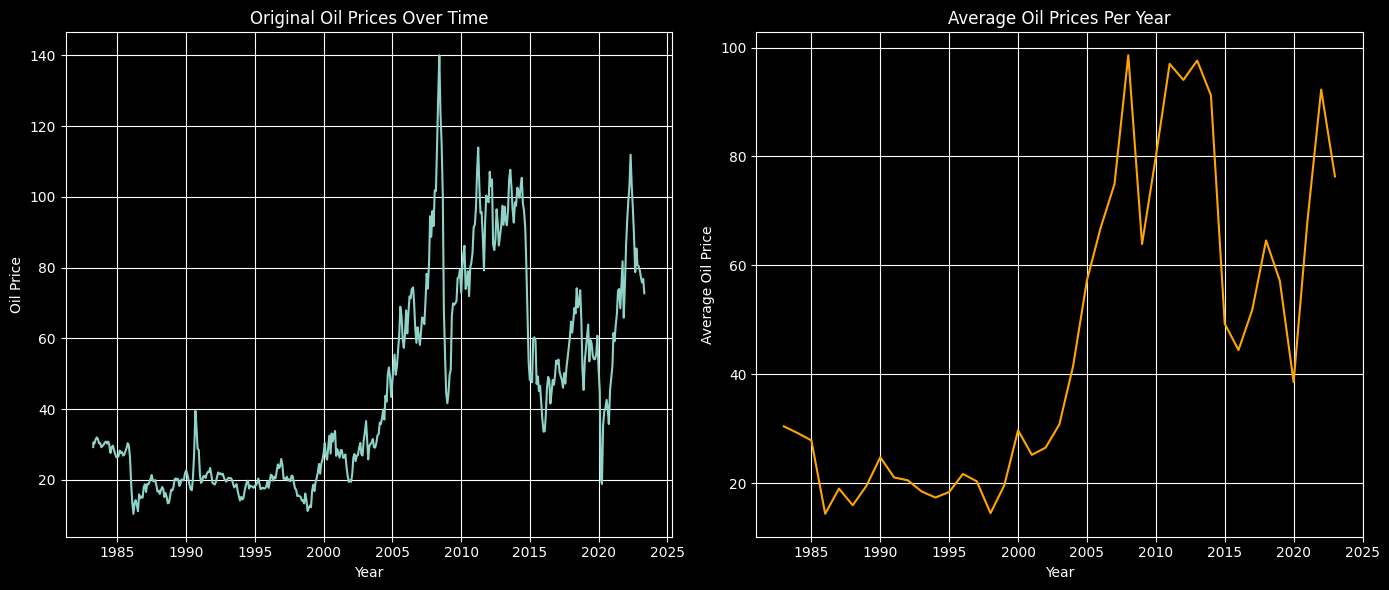

In [14]:
# Plot the original oil prices over time
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(oil_prices['date'], oil_prices['price'], label='Original Data')
plt.title('Original Oil Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Oil Price')
plt.grid(True)

# Plot the average oil prices per year
plt.subplot(1, 2, 2)
plt.plot(avg_oil_price['Year'], avg_oil_price['price'], label='Average per Year', color='orange')
plt.title('Average Oil Prices Per Year')
plt.xlabel('Year')
plt.ylabel('Average Oil Price')
plt.grid(True)

plt.tight_layout()
plt.show()

### Inflation Data

The dataset under consideration contains inflation data for various countries from the year 1970 to 2022.

Our data cleaning and preparation steps include:

- **Filtering rows**: We start by filtering our data to include only those rows related to "Headline Consumer Price Inflation". This is because our analysis focuses only on this particular series.

- **Dropping unnecessary columns**: We remove the last six columns from the dataset as they are not needed for our analysis.

- **Renaming columns**: We rename the 'Country' column to 'Country Name' for better clarity and consistency with other datasets.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

- **Filtering columns**: We further filter our data to include only those columns related to years from 1996 to 2022, along with non-year columns. This is because our analysis focuses on the period from 1996 to 2022.

- **Filling missing values**: Some years in the dataset have missing values. We fill these missing values with the mean value of the rest of the years for that country.

- **Removing invalid rows**: We remove any rows that still have null values after our data cleaning process.

In [15]:
# consider only Headline Consumer Price Inflation
inflation = inflation[inflation['Series Name'] == 'Headline Consumer Price Inflation']
inflation.drop(inflation.columns[-6:], axis=1, inplace=True)
# renaming the 'Country' column to be consistent
inflation = inflation.rename(columns={'Country': 'Country Name'})
# Change the type of year columns to float
for col in inflation.columns[5:]:
    inflation[col] = inflation[col].astype(float)

In [16]:
# Filter columns
cols = [col for col in inflation.columns if (col.isdigit() and int(col) >= 1996) or not col.isdigit()]

# Select those columns from inflation
inflation = inflation[cols]

In [17]:
# Select the columns that you want to operate on
year_cols = inflation.columns[5:]

# Replace NaN values with row mean
inflation.loc[:, year_cols] = inflation.loc[:, year_cols].apply(lambda x: x.fillna(x.mean()), axis=1)

# Get rid of the rest of the NaN values
inflation = inflation.dropna()

### Fertility

The dataset under consideration contains fertility data for various countries from the year 1973 to 2021. The fertility rate data is based on the total fertility rate (TFR), which is the number of children that would be born per woman if all women lived to the end of their childbearing years and bore children according to a given fertility rate at each age.

Our data cleaning and preparation steps include:

- **Renaming columns**: The year columns are initially named in the format 'YYYY [YRYYYY]'. We rename these to just 'YYYY' for simplicity and ease of access.

- **Removing unnecessary rows**: We remove the last seven rows from the dataset as they do not correspond to any country.

- **Filtering columns**: We further filter our data to include only those columns related to years from 1996 to 2021, along with the 'Country Name' and 'Country Code' columns. This is because our analysis focuses on the period from 1996 to 2021.


In [18]:
# renaming the columns by removing [YR]
fertility = fertility.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in fertility.columns[4:]})

# removing the last rows that are not countries
fertility.drop(fertility.index[-7:], axis=0, inplace=True)

# Filter the years to include only those from 1996 to 2021
fertility_columns = ['Country Name', 'Country Code'] + [f'{year}' for year in range(1996, 2022)]
fertility = fertility[fertility_columns].copy()

# Some countries don't have the fertility data for so many years
# We will remove those countries
fertility = fertility.dropna()

### Migration

In [19]:
migration.rename(columns={'country_code': 'Country Code', 'country_name': 'Country Name', 
                          'year': 'Year', 'value': 'Migration'}, inplace=True)

In [20]:
migration.head()

,Country Code,Country Name,Year,Migration
0,ABW,Aruba,1960,0.0
1,ABW,Aruba,1961,-569.0
2,ABW,Aruba,1962,-609.0
3,ABW,Aruba,1963,-646.0
4,ABW,Aruba,1964,-684.0


### CO2 Emissions

In [21]:
# Renaming the columns for consistency
co2_emission.rename(columns={'Annual CO₂ emissions': 'co2_emission', 
                             'Code': 'Country Code',
                             'Entity': 'Country Name'}, inplace=True)

# Getting the emission data after the year 1996 and onwards
co2_emission = co2_emission.query("Year >= 1996")

In [22]:
co2_emission.dropna(subset=['Country Code'])

,Country Name,Country Code,Year,co2_emission
47,Afghanistan,AFG,1996,1370104.00
48,Afghanistan,AFG,1997,1304152.00
49,Afghanistan,AFG,1998,1278504.00
50,Afghanistan,AFG,1999,1091640.00
51,Afghanistan,AFG,2000,1047127.94
...,...,...,...,...
31344,Zimbabwe,ZWE,2017,9596071.00
31345,Zimbabwe,ZWE,2018,11795478.00
31346,Zimbabwe,ZWE,2019,11114607.00
31347,Zimbabwe,ZWE,2020,10607897.00


### Melting and Combining dateframes

In [23]:
## Helper functions
def change_column_types(df, first_col, second_col):
    df[first_col] = df[first_col].astype(int)
    df[second_col] = df[second_col].astype(float)
    return df

In [24]:
# Drop unwanted columns
pop_stab = pop_stab.drop(['Series Name', 'Series Code'], axis=1)

# Melt the dataframe
pop_stab_melted = pop_stab.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Stability")
pop_stab_melted = change_column_types(pop_stab_melted, 'Year', 'Stability')
pop_stab_melted = pop_stab_melted[(pop_stab_melted['Year'] >= 1996) & (pop_stab_melted['Year'] <= 2021)]

In [25]:
# Drop unwanted columns
pop = pop.drop(['Series Name', 'Series Code'], axis=1)

# Melt the dataframe
pop_melted = pop.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Population")
pop_melted = change_column_types(pop_melted, 'Year', 'Population')
pop_melted = pop_melted[(pop_melted['Year'] >= 1996) & (pop_melted['Year'] <= 2021)]

In [26]:
# Drop unwanted columns
urban_pop = urban_pop.drop(['Indicator Name', 'Indicator Code'], axis=1)

# Melt the dataframe
urban_pop_melted = urban_pop.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Urban_Population")
urban_pop_melted = change_column_types(urban_pop_melted, 'Year', 'Urban_Population')
urban_pop_melted = urban_pop_melted[(urban_pop_melted['Year'] >= 1996) & (urban_pop_melted['Year'] <= 2021)]

In [27]:
# Melt the dataframe
hdi_df_melted = hdi_data.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="HDI")
hdi_df_melted = change_column_types(hdi_df_melted, 'Year', 'HDI')
hdi_df_melted = hdi_df_melted[(hdi_df_melted['Year'] >= 1996) & (hdi_df_melted['Year'] <= 2021)]

In [28]:
life_exp_df_melted  =  le_data.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Life_Expectancy")
life_exp_df_melted = change_column_types(life_exp_df_melted, 'Year', 'Life_Expectancy')
life_exp_df_melted = life_exp_df_melted[(life_exp_df_melted['Year'] >= 1996) & (life_exp_df_melted['Year'] <= 2021)]

In [29]:
# Drop unwanted columns
gdp = gdp.drop(['Series Name', 'Series Code'], axis=1)
gdp_melted  =  gdp.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="GDP")
gdp_melted = change_column_types(gdp_melted, 'Year', 'GDP')
gdp_melted = gdp_melted[(gdp_melted['Year'] >= 1996) & (gdp_melted['Year'] <= 2021)]

In [30]:
# Drop unwanted columns
inflation = inflation.drop(['IMF Country Code', 'Series Name', 'Indicator Type'], axis=1)
inflation_melted  =  inflation.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Inflation")
inflation_melted = change_column_types(inflation_melted, 'Year', 'Inflation')
inflation_melted = inflation_melted[(inflation_melted['Year'] >= 1996) & (inflation_melted['Year'] <= 2021)]

In [31]:
fertility_melted = fertility.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Fertility")
fertility_melted = change_column_types(fertility_melted, 'Year', 'Fertility')

In [32]:
fertility_melted.head()

,Country Name,Country Code,Year,Fertility
0,Afghanistan,AFG,1996,7.709
1,Albania,ALB,1996,2.615
2,Algeria,DZA,1996,3.136
3,Angola,AGO,1996,6.851
4,Antigua and Barbuda,ATG,1996,2.266


In [33]:
avg_oil_price_melted = change_column_types(avg_oil_price, 'Year', 'price')
avg_oil_price_melted = avg_oil_price_melted[(avg_oil_price_melted['Year']>=1996) & (avg_oil_price_melted['Year']<=2021)]

In [34]:
# Filtering the co2_emission dataframe for the years 1996 to 2021
#co2_emission = co2_emission[(co2_emission['Year'] >= 1996) & (co2_emission['Year'] <= 2021)]

In [35]:
query = """
SELECT A.'Country Name' as 'Country Name', A.'Country Code', A.Year, A.Stability, B.Inflation, 
        C.Population, D.Urban_Population, E.HDI, F.Life_Expectancy, G.GDP, H.Migration,
        I.Fertility, J.co2_emission

FROM pop_stab_melted AS A
INNER JOIN inflation_melted AS B ON A.'Country Code' = B.'Country Code' AND A.Year = B.Year
INNER JOIN pop_melted AS C ON A.'Country Code' = C.'Country Code' AND A.Year = C.Year
INNER JOIN urban_pop_melted AS D ON A.'Country Code' = D.'Country Code' AND A.Year = D.Year
INNER JOIN hdi_df_melted AS E ON A.'Country Code' = E.'Country Code' AND A.Year = E.Year
INNER JOIN life_exp_df_melted AS F ON A.'Country Code' = F.'Country Code' AND A.Year = F.Year
INNER JOIN gdp_melted AS G ON A.'Country Code' = G.'Country Code' AND A.Year = G.Year
INNER JOIN migration AS H ON A.'Country Code' = H.'Country Code' AND A.Year = H.Year
INNER JOIN fertility_melted AS I ON A.'Country Code' = I.'Country Code' AND A.Year = I.Year
INNER JOIN co2_emission AS J ON A.'Country Code' = J.'Country Code' AND A.Year = J.Year
"""

merged_df = ps.sqldf(query, locals())

In [36]:
merged_df.to_csv('test.csv')

In [37]:
merged_df.head()

,Country Name,Country Code,Year,Stability,Inflation,Population,Urban_Population,HDI,Life_Expectancy,GDP,Migration,Fertility,co2_emission
0,Afghanistan,AFG,1996,-2.417310,14.01,17106595.0,21.714,0.319,53.2433,3.854235e+09,27194.0,7.709,1370104.0
1,Albania,ALB,1996,-0.336625,12.80,3168033.0,39.473,0.645,74.5923,3.199641e+09,-65800.0,2.615,2017508.0
2,Algeria,DZA,1996,-1.783311,18.70,28984634.0,56.774,0.617,68.7493,4.694158e+10,-9849.0,3.136,96786280.0
3,Angola,AGO,1996,-2.061917,4146.01,14383350.0,45.346,0.364,46.0329,7.526447e+09,45356.0,6.851,10423993.0
4,Antigua and Barbuda,ATG,1996,0.717077,2.96,69798.0,33.590,0.802,73.8291,6.337296e+08,478.0,2.266,238160.0


In [46]:
# Prepare data
grouped = merged_df.groupby('Country Name')
time_series_data = []
country_names = []  # List to keep track of country names
for name, group in grouped:
    group = group.sort_values('Year')
    time_series_data.append(group[["Stability","Inflation","Population","Urban_Population","HDI","Life_Expectancy","GDP","Migration", "Fertility"]].values)
    country_names.append(name)  # Add country name to the list

In [64]:
# Data normalization
time_series_data = [TimeSeriesScalerMeanVariance().fit_transform(ts).squeeze() for ts in time_series_data]
X = to_time_series_dataset(time_series_data)

# Clustering
model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=5, random_state=0)
model.fit(X)

TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=5, random_state=0)

In [62]:
# Get the cluster assignments for each time series
labels = model.labels_

# Group country names by cluster
clusters = {i: [] for i in range(5)}
for country_name, label in zip(country_names, labels):
    clusters[label].append(country_name)

for i in range(5):
    print(f"Countries in cluster {i+1}: {', '.join(clusters[i])}")

Countries in cluster 1: Angola, Armenia, Azerbaijan, Bhutan, Bolivia, Cameroon, China, Comoros, Congo, Rep., Cote d'Ivoire, Djibouti, Egypt, Arab Rep., Georgia, Guyana, Honduras, Indonesia, Iraq, Kiribati, Mauritania, Moldova, Mongolia, Nicaragua, Nigeria, Papua New Guinea, Philippines, Sao Tome and Principe, Senegal, Solomon Islands, Sri Lanka, Sudan, Turkmenistan, Ukraine
Countries in cluster 2: Antigua and Barbuda, Argentina, Australia, Austria, Bahamas, The, Bahrain, Barbados, Belgium, Belize, Botswana, Brazil, Brunei Darussalam, Canada, Chile, Costa Rica, Croatia, Cyprus, Czech Republic, Denmark, Dominica, Estonia, Finland, France, Gabon, Germany, Greece, Grenada, Hong Kong SAR, China, Hungary, Iceland, Ireland, Israel, Italy, Jamaica, Japan, Korea, Rep., Kuwait, Latvia, Lebanon, Libya, Lithuania, Luxembourg, Malaysia, Malta, Mauritius, Mexico, Netherlands, New Zealand, Norway, Oman, Panama, Poland, Portugal, Qatar, Saudi Arabia, Singapore, Slovak Republic, Slovenia, South Africa,

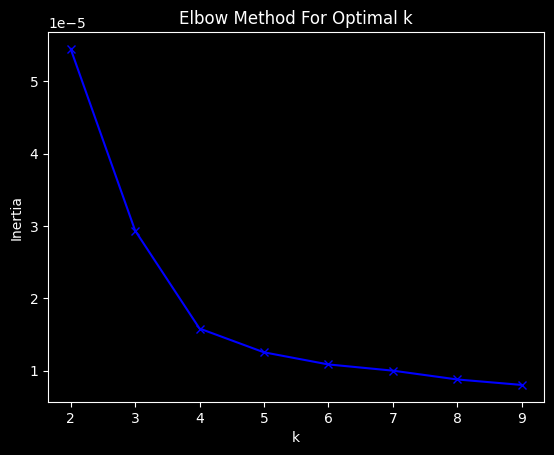

In [66]:
inertia = []
range_n_clusters = range(2, 10)  # Adjust depending on your data

for n_clusters in range_n_clusters:
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0)
    model.fit(X)
    inertia.append(model.inertia_)

# Plot inertia for each value of k
plt.figure()
plt.plot(range_n_clusters, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [183]:
clusters_df = pd.DataFrame(clusters.items(), columns=['Cluster', 'Countries'])
clusters_df.head

,Cluster,Countries
0,0,"[Albania, Armenia, Azerbaijan, Bhutan, Bolivia..."
1,1,"[Burundi, Congo, Dem. Rep., Ethiopia, Malawi, ..."
2,2,"[Algeria, Antigua and Barbuda, Argentina, Aust..."
3,3,"[Afghanistan, Burkina Faso, Cambodia, Central ..."
4,4,"[Angola, Bangladesh, Benin, Gambia, The, Ghana..."


In [72]:
cluster_1 = clusters[0]
cluster_2 = clusters[1]
cluster_3 = clusters[2]
cluster_4 = clusters[3]
cluster_5 = clusters[4]

In [77]:
# Filter the dataframe to include only the countries in cluster 1
cluster_1_df = merged_df[merged_df['Country Name'].isin(cluster_1)]

# Filter the dataframe to include only the countries in cluster 2
cluster_2_df = merged_df[merged_df['Country Name'].isin(cluster_2)]

# Filter the dataframe to include only the countries in cluster 3
cluster_3_df = merged_df[merged_df['Country Name'].isin(cluster_3)]

# Filter the dataframe to include only the countries in cluster 4
cluster_4_df = merged_df[merged_df['Country Name'].isin(cluster_4)]

# Filter the dataframe to include only the countries in cluster 5
cluster_5_df = merged_df[merged_df['Country Name'].isin(cluster_5)]

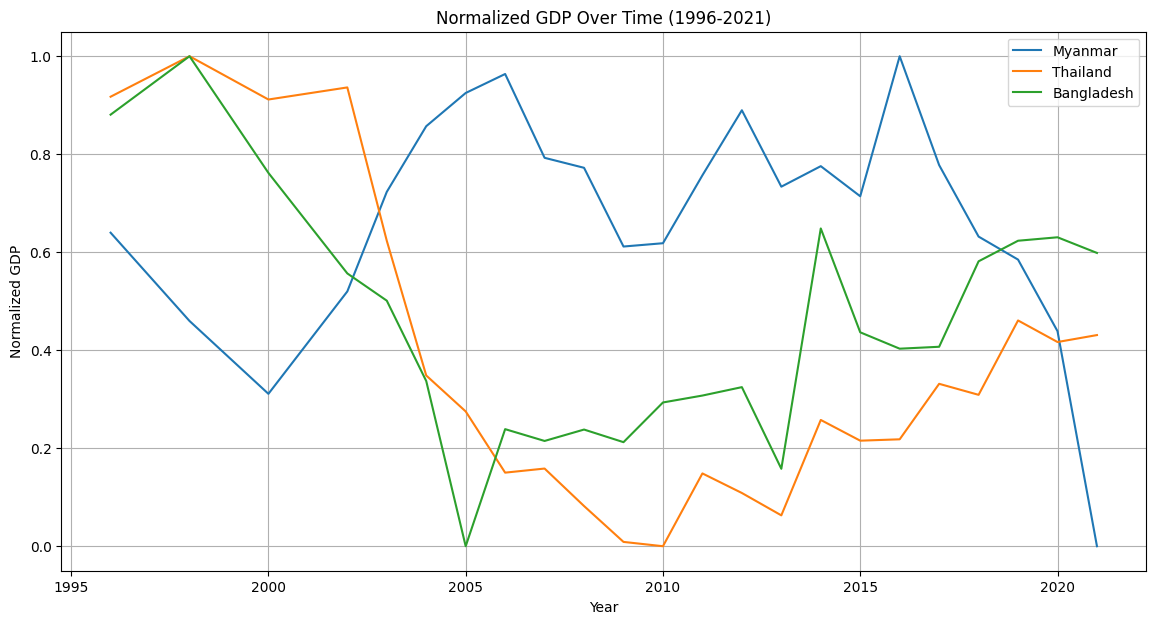

In [187]:
# Assuming the dataframe test_data is the GDP data
# Create a list of countries
countries = ["Myanmar", "Thailand", "Bangladesh"]

# Filter the data for the given countries
gdp_data = pop_stab[pop_stab['Country Name'].isin(countries)]

# Melt the dataframe to have years in a single column and GDP values in another
gdp_data_melted = pop_stab.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='GDP')

# Convert year to numeric type
gdp_data_melted['Year'] = pd.to_numeric(gdp_data_melted['Year'])

# Normalize the GDP values for each country based on its own maximum GDP value
gdp_data_melted['GDP_normalized'] = gdp_data_melted.groupby('Country Name')['GDP'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Plot the normalized GDP of each country over years
plt.figure(figsize=[14,7])
for country in countries:
    data = gdp_data_melted[gdp_data_melted['Country Name'] == country]
    plt.plot(data['Year'], data['GDP_normalized'], label=country)

plt.title('Normalized GDP Over Time (1996-2021)')
plt.xlabel('Year')
plt.ylabel('Normalized GDP')
plt.legend()
plt.grid(True)
plt.show()


In [126]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator

# We will predict the co2_emission, so we'll treat it as our target variable
target = "co2_emission"

# Create a copy of the dataframe to avoid modifying the original
data_lstm = cluster_1_df.copy()

# Drop unnecessary columns
data_lstm.drop(columns=["Country Name", "Country Code"], inplace=True)

# The LSTM expects data to have a certain shape, we need to prepare the data accordingly

# Create a dict to hold the data for each country
country_data_dict = {}

# Normalize the data to aid LSTM training
scaler = MinMaxScaler()

# Go through each country and prepare the data
for country_code in cluster_1_df["Country Code"].unique():
    # Get the data for this country
    country_data = data_lstm[cluster_1_df["Country Code"] == country_code].copy()  # Create a copy here
    
    # Sort the data by Year
    country_data = country_data.sort_values("Year")  # Assign the result back instead of sorting in-place
    
    # Normalize the data
    country_data = pd.DataFrame(scaler.fit_transform(country_data), columns=country_data.columns)
    
    # Drop the Year column
    country_data = country_data.drop(columns=["Year"])  # Assign the result back instead of dropping in-place
    
    # Convert the data to the format expected by the LSTM
    country_data_dict[country_code] = country_data.values

# Split the data into training and testing sets
train_data_dict = {country_code: country_data[:-int(len(country_data)*0.2)] for country_code, country_data in country_data_dict.items()}
test_data_dict = {country_code: country_data[-int(len(country_data)*0.2):] for country_code, country_data in country_data_dict.items()}

In [133]:
# Generate sequences for training
# We'll use a sliding window approach where we use the past N years of data to predict the next year's co2_emission
N = 3  # window size

train_sequences = []
train_targets = []

for country_data in train_data_dict.values():
    for i in range(N, len(country_data)):
        train_sequences.append(country_data[i-N:i])
        train_targets.append(country_data[i][-1])  # The target is the last column, co2_emission

train_sequences = np.array(train_sequences)
train_targets = np.array(train_targets)

# We'll do the same for the testing data
test_sequences = []
test_targets = []

for country_data in test_data_dict.values():
    for i in range(N, len(country_data)):
        test_sequences.append(country_data[i-N:i])
        test_targets.append(country_data[i][-1])  # The target is the last column, co2_emission

test_sequences = np.array(test_sequences)
test_targets = np.array(test_targets)

train_sequences.shape, test_sequences.shape


((576, 3, 10), (64, 3, 10))

In [134]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(train_sequences.shape[1], train_sequences.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_sequences, train_targets, epochs=200, verbose=0)

# Evaluate the model
loss = model.evaluate(test_sequences, test_targets, verbose=0)
print(f'Test Loss: {loss}')


Test Loss: 0.08739791810512543


In [ ]:
# We'll do the same for the testing data
test_sequences = []
test_targets = []

for country_data in test_data_dict.values():
    for i in range(N, len(country_data)):
        test_sequences.append(country_data[i-N:i])
        test_targets.append(country_data[i][-1])  # The target is the last column, co2_emission

test_sequences = np.array(test_sequences)
test_targets = np.array(test_targets)

train_sequences.shape, test_sequences.shape


NameError: name 'country_data' is not defined